
## Understanding Embedding Models and Similarity

<a href="https://colab.research.google.com/github/adithya-s-k/AI-Engineering.academy/blob/main/RAG/00_RAG_from_Scratch/Understanding_embeddings_and_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q sentence-transformers
!pip install -q wikipedia-api
!pip install -q numpy
!pip install -q scipy
!pip install rich
!pip install pypdf2

In [12]:
import re
import os
from rich import print
from sentence_transformers import SentenceTransformer
import numpy as np
import textwrap
from IPython.display import display, HTML

Load Data

In [8]:
from wikipediaapi import Wikipedia
wiki = Wikipedia('RAGBot/0.0', 'en')
data = wiki.page('Hayao_Miyazaki').text

## After Uploading a pdf
# data = load_document("/content/R_Tamil_LLama.pdf")

print(data)

TAMIL -LLAMA : A N EWTAMIL LANGUAGE MODEL BASED ON
LLAMA 2
Abhinand Balachandran
abhinandb.ml@gmail.com
ABSTRACT
Language modeling has witnessed remarkable advancements in recent years, with Large Language
Models (LLMs) like ChatGPT setting unparalleled benchmarks in human-like text generation. How-
ever, a prevailing limitation is the underrepresentation of languages like Tamil in these cutting-edge
models, leading to suboptimal performance in diverse linguistic contexts. This paper addresses this
lacuna, enhancing the open-source LLaMA model with an addition of 16,000 Tamil tokens, aiming to
achieve superior text generation and comprehension in the Tamil language. We strategically employ
the LoRA methodology for efficient model training on a comprehensive Tamil corpus, ensuring com-
putational feasibility and model robustness. Moreover, we introduce a Tamil-translated version of the
Alpaca dataset and a subset of the OpenOrca dataset tailored for instruction fine-tuning. Our results
showcase significant performance improvements in Tamil text generation, with potential implications
for the broader landscape of LLMs in Indian languages. We further underscore our commitment
to open research by making our models, datasets, and code1publicly accessible, fostering further
innovations in language modeling.
1 Introduction
The past few years have been transformative for language modeling, with groundbreaking advances and monumental
achievements. At the forefront of this revolution was OpenAI’s ChatGPT (OpenAI, 2022), which not only raised the
bar in language modeling performance but also underscored the immense societal implications of such technologies.
Alongside ChatGPT, various Large Language Models (LLMs) have consistently demonstrated exceptional prowess in
natural language understanding and generation, heralding a new era in computational linguistics.
Central to the functionality of these modern LLMs is the Transformer architecture, a cornerstone concept brought to
the limelight by "Attention is All You Need" (Vaswani et al., 2017). This innovation transformed our approach to
sequence-based tasks, catalyzing pivotal models like BERT (Devlin et al., 2019) and redefining best practices in 
Natural
Language Processing (NLP).
Subsequent developments, particularly the Generative Pre-trained Transformer (GPT) (Radford et al., 2018), 
showcased
the profound potential of unsupervised pre-training on vast datasets. Models like GPT-3 and its successor, GPT-4
(OpenAI, 2023), have redefined benchmarks and fueled a renaissance in natural language understanding and 
generation.
Beyond their technical prowess, they have prompted a renewed vigor in exploring the limits of Artificial General
Intelligence (AGI). These advancements, paired with exemplary performance in numerous applications, have galvanized
the NLP community, sparking widespread application and research from sentiment analysis to machine translation.
However, progress is not without its pitfalls. The elite LLMs, despite their remarkable capabilities, grapple with
challenges—primarily, their proprietary nature, which constricts open research. Furthermore, an English-centric
bias and the enormous computational requirements for training such behemoths further accentuate the call for more
accessible and diverse solutions.
In response, the open-source community has championed the creation of models like LLaMA (Touvron et al., 2023a)
and Mistral (Jiang et al., 2023). Such models, despite their compact nature, challenge the hegemony of giants like
ChatGPT in select benchmarks, heralding a promising direction for future research.
1GitHub Repository: https://github.com/abhinand5/tamil-llamaarXiv:2311.05845v1    10 Nov 2023However, as robust as 
these models, like LLaMA and Mistral, might be, their proficiency in generating coherent text in
Tamil and several other Indian languages remains noticeably deficient. A fundamental limitation lies in their 
minimal
vocabulary of Tamil characters, 

Perform Chunking

In [15]:
def chunk_text(text, chunk_size=1000, overlap=20):
    """
    Split the text into chunks based on the number of words and word overlap.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

chunked_data = chunk_text(data)

print("Total number of chunks", len(chunked_data))

Total number of chunks 10

Visualise Chunking

In [17]:
def print_chunks(chunks):
    """
    Display text chunks in a clean, readable format using HTML styling.

    Args:
        chunks (list): List of text chunks to display
    """
    # Create the HTML for the chunks display
    html_content = """
    <style>
        .chunk-container {
            font-family: Arial, sans-serif;
            margin: 20px 0;
        }
        .chunk-header {
            background-color: #f0f2f6;
            padding: 5px 10px;
            border-radius: 5px 5px 0 0;
            border-left: 4px solid #3498db;
            font-weight: bold;
            color: #2c3e50;
        }
        .chunk-content {
            background-color: #ffffff;
            color: #2c3e50;
            padding: 10px;
            border: 1px solid #e1e4e8;
            border-left: 4px solid #3498db;
            border-top: none;
            border-radius: 0 0 5px 5px;
            white-space: pre-wrap;
            font-family: monospace;
        }
    </style>
    """

    # Add each chunk to the HTML content
    for i, chunk in enumerate(chunks, 1):
        # Wrap text for better readability
        wrapped_text = textwrap.fill(chunk, width=100)

        html_content += f"""
        <div class="chunk-container">
            <div class="chunk-header">Chunk {i}</div>
            <div class="chunk-content">{wrapped_text}</div>
        </div>
        """

    # Display the HTML
    display(HTML(html_content))
print_chunks(chunked_data)

Setting Up embedding model

In [ ]:
# Load the sentence transformer model for embeddings

model = SentenceTransformer("Alibaba-NLP/gte-base-en-v1.5", trust_remote_code=True)
# model = SentenceTransformer("BAAI/bge-small-en-v1.5", trust_remote_code=True)
# model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=True)

set up similarity function


Understanding Cosine Similarity : [refrence video](https://www.youtube.com/watch?v=zcUGLp5vwaQ)

In [ ]:
def cosine_similarity(vector_a, vector_b):
    """
    Calculate the cosine similarity between two vectors.
    Cosine similarity measures how similar two vectors are by calculating the cosine of the angle between them.

    Args:
        vector_a: First vector (numpy array)
        vector_b: Second vector (numpy array)

    Returns:
        float: Similarity score between -1 and 1
               1: Vectors are identical
               0: Vectors are perpendicular
              -1: Vectors are opposite
    """
    # Step 1: Calculate the dot product between the vectors
    # Dot product measures how much vectors point in the same direction
    dot_product = np.dot(vector_a, vector_b)

    # Step 2: Calculate the magnitude (length) of each vector
    # Magnitude is the square root of the sum of squared values
    magnitude_a = np.linalg.norm(vector_a)  # √(a1² + a2² + ... + an²)
    magnitude_b = np.linalg.norm(vector_b)  # √(b1² + b2² + ... + bn²)

    # Step 3: Calculate the cosine similarity
    # Divide dot product by the product of magnitudes
    similarity = dot_product / (magnitude_a * magnitude_b)

    return similarity

understanding similarity between two sentences

In [23]:
## Change the sentences accordingly

sentence1 = "The cat sat on the mat"
sentence2 = "A cat is sitting on a mat"

In [24]:
def get_similarity_score(sentence1, sentence2):
    """
    Calculate similarity score between two sentences.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence

    Returns:
        float: Similarity score between 0 and 1
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)

    # Calculate similarity
    similarity = np.dot(embedding1, embedding2)

    return similarity

# change the sentences


score = get_similarity_score(sentence1, sentence2)
print(f"Similarity score: {score:.4f}")

Similarity score: 0.9067

visualise embeddings

Similarity Score: 0.9067

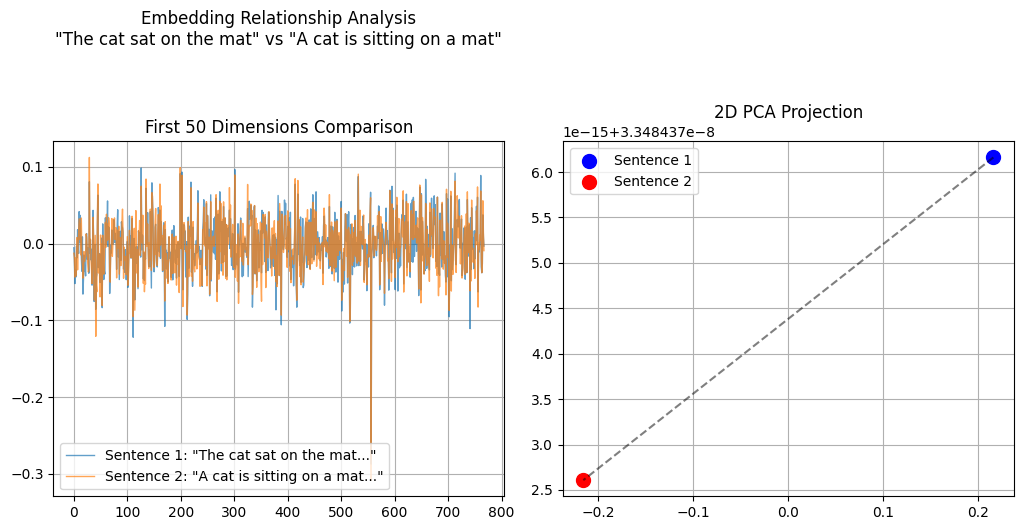

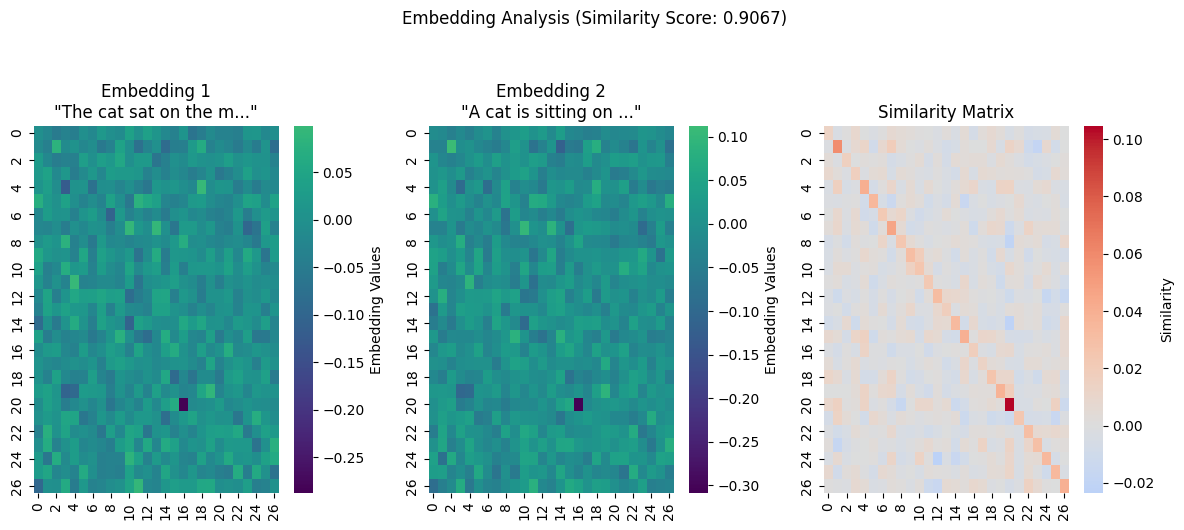

0.90672314

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def visualize_embeddings(sentence1, sentence2):
    """
    Visualize the relationship between two sentence embeddings using
    multiple visualization techniques.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)
    dimensions = range(len(embedding1))

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 5))


    # Dimension-wise Comparison
    plt.subplot(132)
    plt.plot(dimensions, embedding1,
             label=f'Sentence 1: "{sentence1[:30]}..."',
             alpha=0.7,
             linewidth=1)
    plt.plot(dimensions, embedding2,
             label=f'Sentence 2: "{sentence2[:30]}..."',
             alpha=0.7,
             linewidth=1)
    plt.title('Comparison')
    plt.legend()
    plt.grid(True)

    # 2D PCA Projection
    plt.subplot(133)
    # Combine embeddings and apply PCA
    combined_embeddings = np.vstack([embedding1, embedding2])
    pca = PCA(n_components=2)
    projected = pca.fit_transform(combined_embeddings)

    plt.scatter(projected[0, 0], projected[0, 1], c='blue', label='Sentence 1', s=100)
    plt.scatter(projected[1, 0], projected[1, 1], c='red', label='Sentence 2', s=100)
    plt.plot([projected[0, 0], projected[1, 0]],
             [projected[0, 1], projected[1, 1]],
             'k--', alpha=0.5)
    plt.title('2D PCA Projection')
    plt.legend()
    plt.grid(True)

    # Add overall title and adjust layout
    plt.suptitle(f'Embedding Relationship Analysis\n"{sentence1}" vs "{sentence2}"',
                 fontsize=12, y=1.05)
    plt.tight_layout()

    # Calculate and display similarity score
    similarity = np.dot(embedding1, embedding2)
    print(f"Similarity Score: {similarity:.4f}")

    plt.show()

def plot_embedding_heatmap(sentence1, sentence2):
    """
    Create an improved heatmap visualization of embedding similarities.

    Args:
        sentence1 (str): First sentence
        sentence2 (str): Second sentence
    """
    # Get embeddings
    embedding1 = model.encode(sentence1, normalize_embeddings=True)
    embedding2 = model.encode(sentence2, normalize_embeddings=True)

    # Reshape embeddings to 2D matrices for better visualization
    size = int(np.sqrt(len(embedding1)))
    matrix1 = embedding1[:size*size].reshape(size, size)
    matrix2 = embedding2[:size*size].reshape(size, size)

    # Create similarity matrix
    similarity_matrix = np.dot(matrix1, matrix2.T)

    # Plot setup
    plt.figure(figsize=(12, 5))

    # Create subplots for both individual embeddings and their similarity
    plt.subplot(131)
    sns.heatmap(matrix1,
                cmap='viridis',
                center=0,
                cbar_kws={'label': 'Embedding Values'})
    plt.title(f'Embedding 1\n"{sentence1[:20]}..."')

    plt.subplot(132)
    sns.heatmap(matrix2,
                cmap='viridis',
                center=0,
                cbar_kws={'label': 'Embedding Values'})
    plt.title(f'Embedding 2\n"{sentence2[:20]}..."')

    plt.subplot(133)
    sns.heatmap(similarity_matrix,
                cmap='coolwarm',
                center=0,
                cbar_kws={'label': 'Similarity'})
    plt.title('Similarity Matrix')

    # Calculate overall similarity score
    similarity = np.dot(embedding1, embedding2)

    # Add overall title with similarity score
    plt.suptitle(f'Embedding Analysis (Similarity Score: {similarity:.4f})',
                 y=1.05)

    plt.tight_layout()
    plt.show()

    return similarity

visualize_embeddings(sentence1, sentence2)
plot_embedding_heatmap(sentence1, sentence2)

embed chunks

In [ ]:
def simple_visualize_chunks(chunks):
    """
    Create a simple 2D visualization of text chunk relationships.

    Args:
        chunks (list): List of text chunks to visualize
    """
    # Get embeddings and reduce dimensions
    embeddings = model.encode(chunks, normalize_embeddings=True, show_progress_bar=True)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=range(len(chunks)), cmap='viridis')

    # Add labels
    for i, (x, y) in enumerate(reduced):
        plt.annotate(f"Chunk {i+1}", (x, y), xytext=(5, 5), textcoords='offset points')

    plt.title("Text Chunks in 2D Space")
    plt.grid(True, alpha=0.3)
    plt.colorbar(label='Chunk Order')

    plt.tight_layout()
    plt.show()

# Example usage:
# chunked_data = ["hello", "bird", "how are you doing" , "king"]
simple_visualize_chunks(chunked_data)